# **Feature Construction**

Base on the EDA on coef, there are required to have more data so as to increase the prediction power of the model. 

Reference:
- https://github.com/ashishpatel26/Amazing-Feature-Engineering/blob/master/A%20Short%20Guide%20for%20Feature%20Engineering%20and%20Feature%20Selection.md
- https://www.kaggle.com/code/iveeaten3223times/comprehensive-data-visualization

# Loading Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import yfinance as yf
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kevinleungch421/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Connecting to the Database

In [2]:
db_connection = sqlite3.connect('/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite')
data_query = """
SELECT 
    s.date, s.open, s.high, s.low, s.close, s.volume, s.ticker, s.month_year,
    m.Release_Date, m.Unemployment_Actual, m.Unemployment_Predicted,
    m.CPI_Actual, m.CPI_Predicted, m.Nonfarm_Payrolls_Actual, m.Nonfarm_Payrolls_Predicted,
    m.Retail_Sales_Actual, m.Retail_Sales_Predicted, m.Industrial_Production_Actual,
    m.Industrial_Production_Predicted, m.Consumer_Confidence_Index_Actual,
    m.Consumer_Confidence_Index_Predicted, m.Personal_Income_Actual, m.Personal_Income_Predicted,
    n.titles
FROM stock_data s
LEFT JOIN macro_data m ON s.month_year = m.month_year
LEFT JOIN (
    SELECT date, GROUP_CONCAT(title, ', ') AS titles, month_year, ticker
    FROM news_data
    GROUP BY date, month_year, ticker
) n ON s.date = n.date AND s.ticker = n.ticker
"""
stock_macro_news_data = pd.read_sql(data_query, db_connection)
db_connection.close()

In [7]:
display(stock_macro_news_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   date                                 2333 non-null   object 
 1   open                                 2333 non-null   float64
 2   high                                 2333 non-null   float64
 3   low                                  2333 non-null   float64
 4   close                                2333 non-null   float64
 5   volume                               2333 non-null   int64  
 6   ticker                               2333 non-null   object 
 7   month_year                           2333 non-null   object 
 8   Release_Date                         2038 non-null   object 
 9   Unemployment_Actual                  2038 non-null   float64
 10  Unemployment_Predicted               2038 non-null   float64
 11  CPI_Actual                    

None

# Pre-Processing Data
-> sort data within trump 1st term

-> group daily news to monthly news

-> calculate the monthy sentiment score based on vader

In [201]:
def basic_cleaning(cleaned_df, start='2017-01-01', end='2021-01-01'):
    nltk.download('vader_lexicon', quiet=True)
    sid = SentimentIntensityAnalyzer()
    result = cleaned_df.copy()
    result['sentiment_score'] = result['titles'].apply(
        lambda x: sid.polarity_scores(str(x))['compound']
    )
    if 'month_year' not in result.columns:
        result['month_year'] = pd.to_datetime(result['date']).dt.to_period('M')
    result = result.groupby('month_year').agg({
        'titles': lambda x: ' '.join(x.dropna()),
        'sentiment_score': 'mean'
    }).reset_index()
    result.rename(columns={'sentiment_score': 'avg_sentiment_score'}, inplace=True)
    final_df = pd.merge(cleaned_df, result, how='left', on=['month_year'])
    final_df['date'] = pd.to_datetime(final_df['date'])
    final_df.set_index('date', inplace=True)
    final_df = final_df.loc[start:end]
    final_df.drop(['ticker', 'Release_Date', 'titles_x', 'sentiment_score'], axis=1, inplace=True, errors='ignore')
    final_df = final_df.resample('M').last()
    return final_df

In [208]:
eda_df = stock_macro_news_data.copy()
eda_df = process_data(eda_df, start='2017-01-01', end='2021-01-01')
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   open                                 48 non-null     float64
 1   high                                 48 non-null     float64
 2   low                                  48 non-null     float64
 3   close                                48 non-null     float64
 4   volume                               48 non-null     int64  
 5   month_year                           48 non-null     object 
 6   Unemployment_Actual                  48 non-null     float64
 7   Unemployment_Predicted               48 non-null     float64
 8   CPI_Actual                           48 non-null     float64
 9   CPI_Predicted                        48 non-null     float64
 10  Nonfarm_Payrolls_Actual              48 non-null     float64
 11  Nonfar

# Add Target

In [200]:
def add_target(final_df):
    final_df["Future_Log_Returns"] = np.log(final_df['close']).diff(1).shift(-1)
    return final_df

In [209]:
eda_df = add_target(eda_df)
eda_df["Future_Log_Returns"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Series name: Future_Log_Returns
Non-Null Count  Dtype  
--------------  -----  
47 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


# Problems
-> in the coef task, there are lack of variable that impact the target, which inspire for add new variable

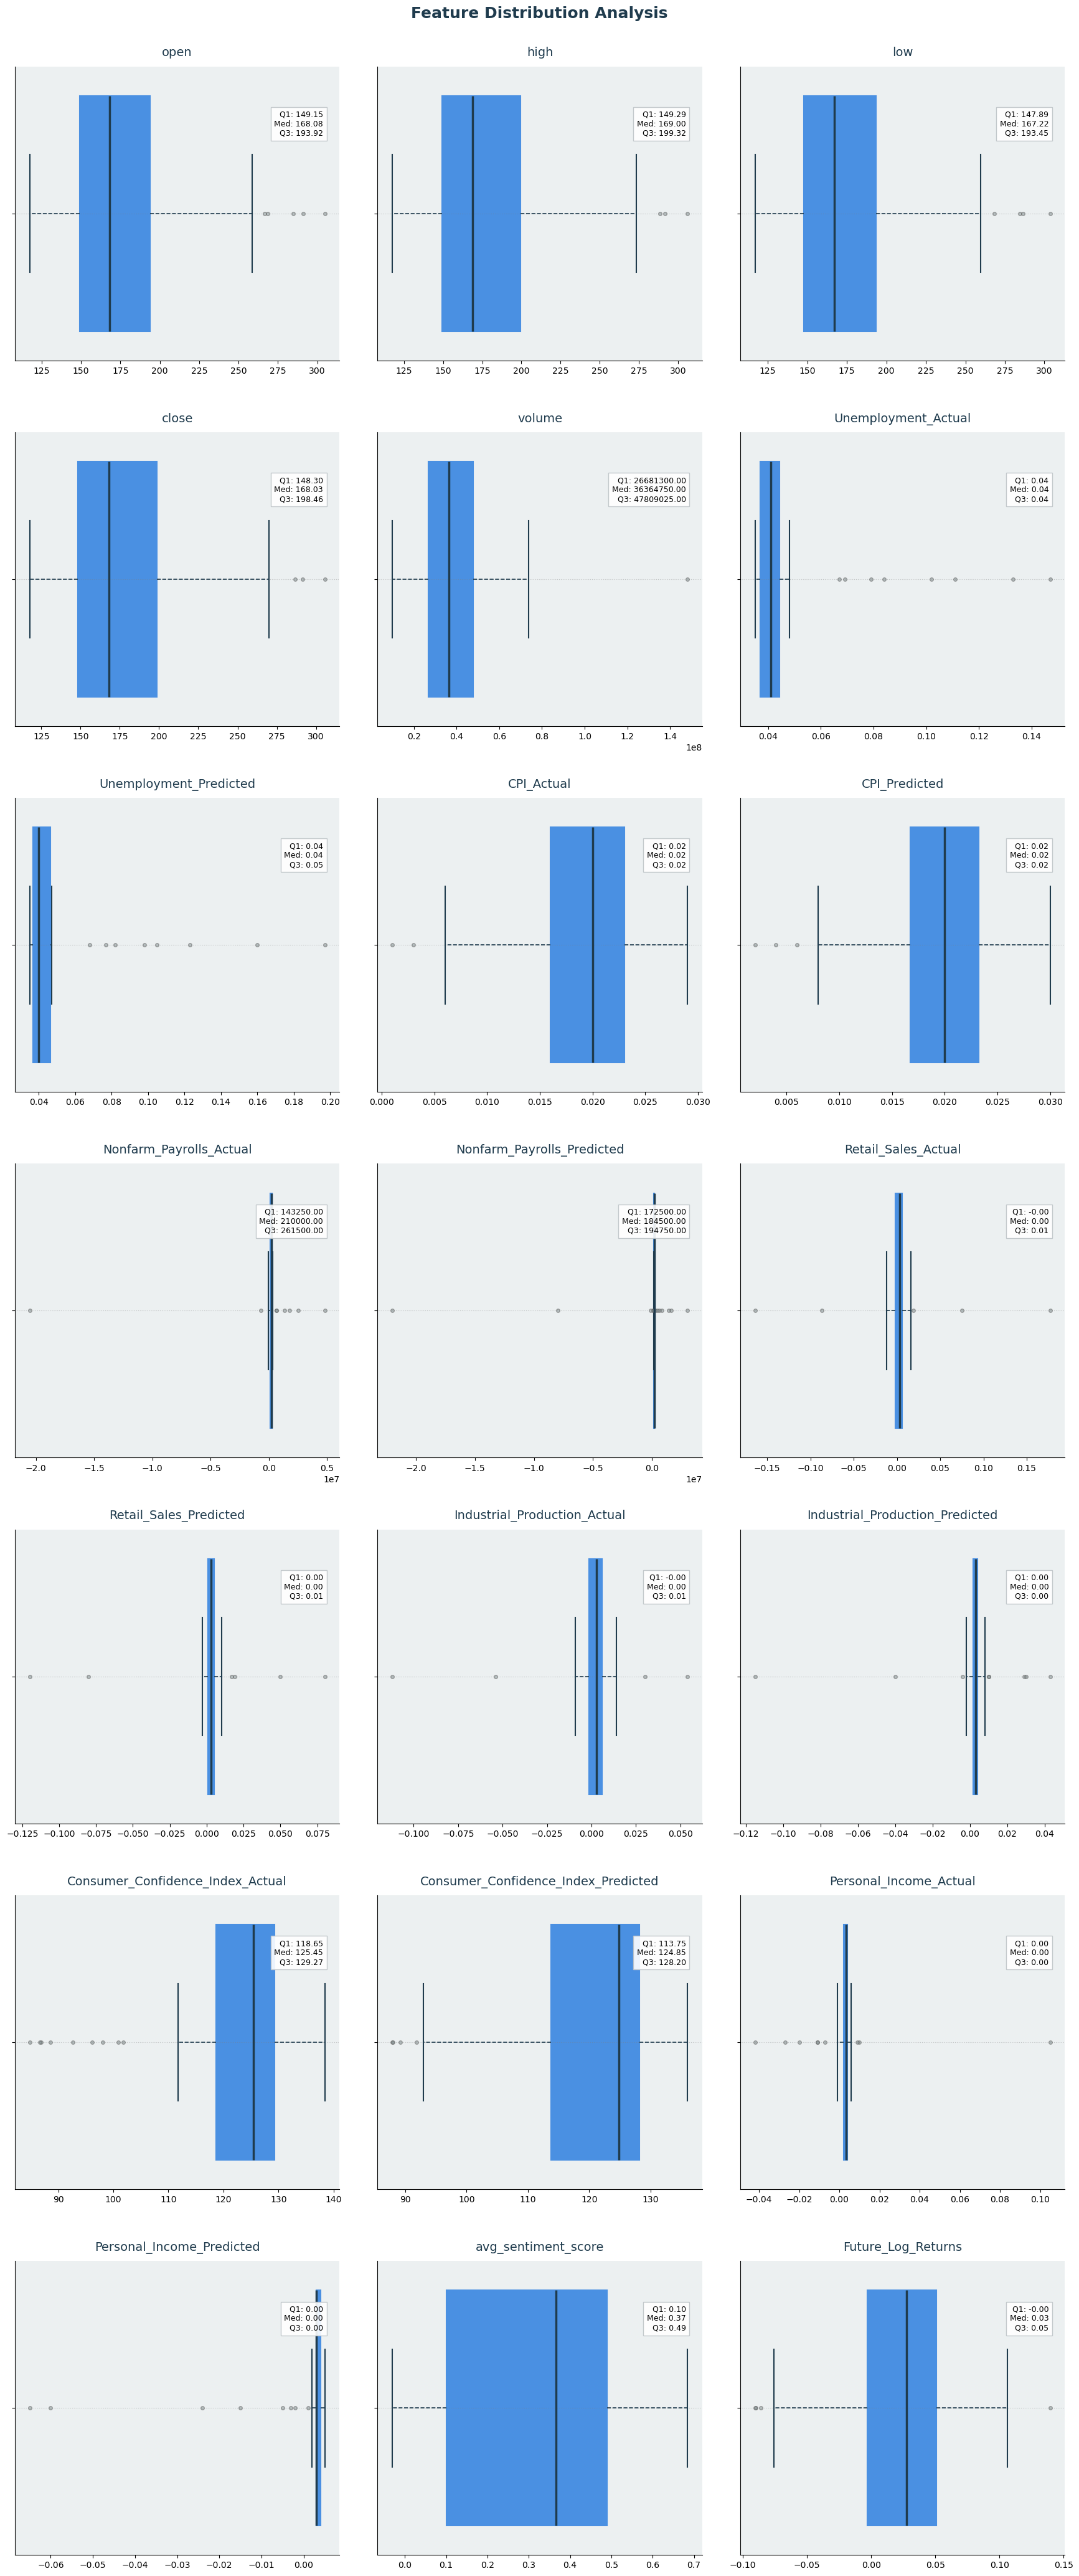

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

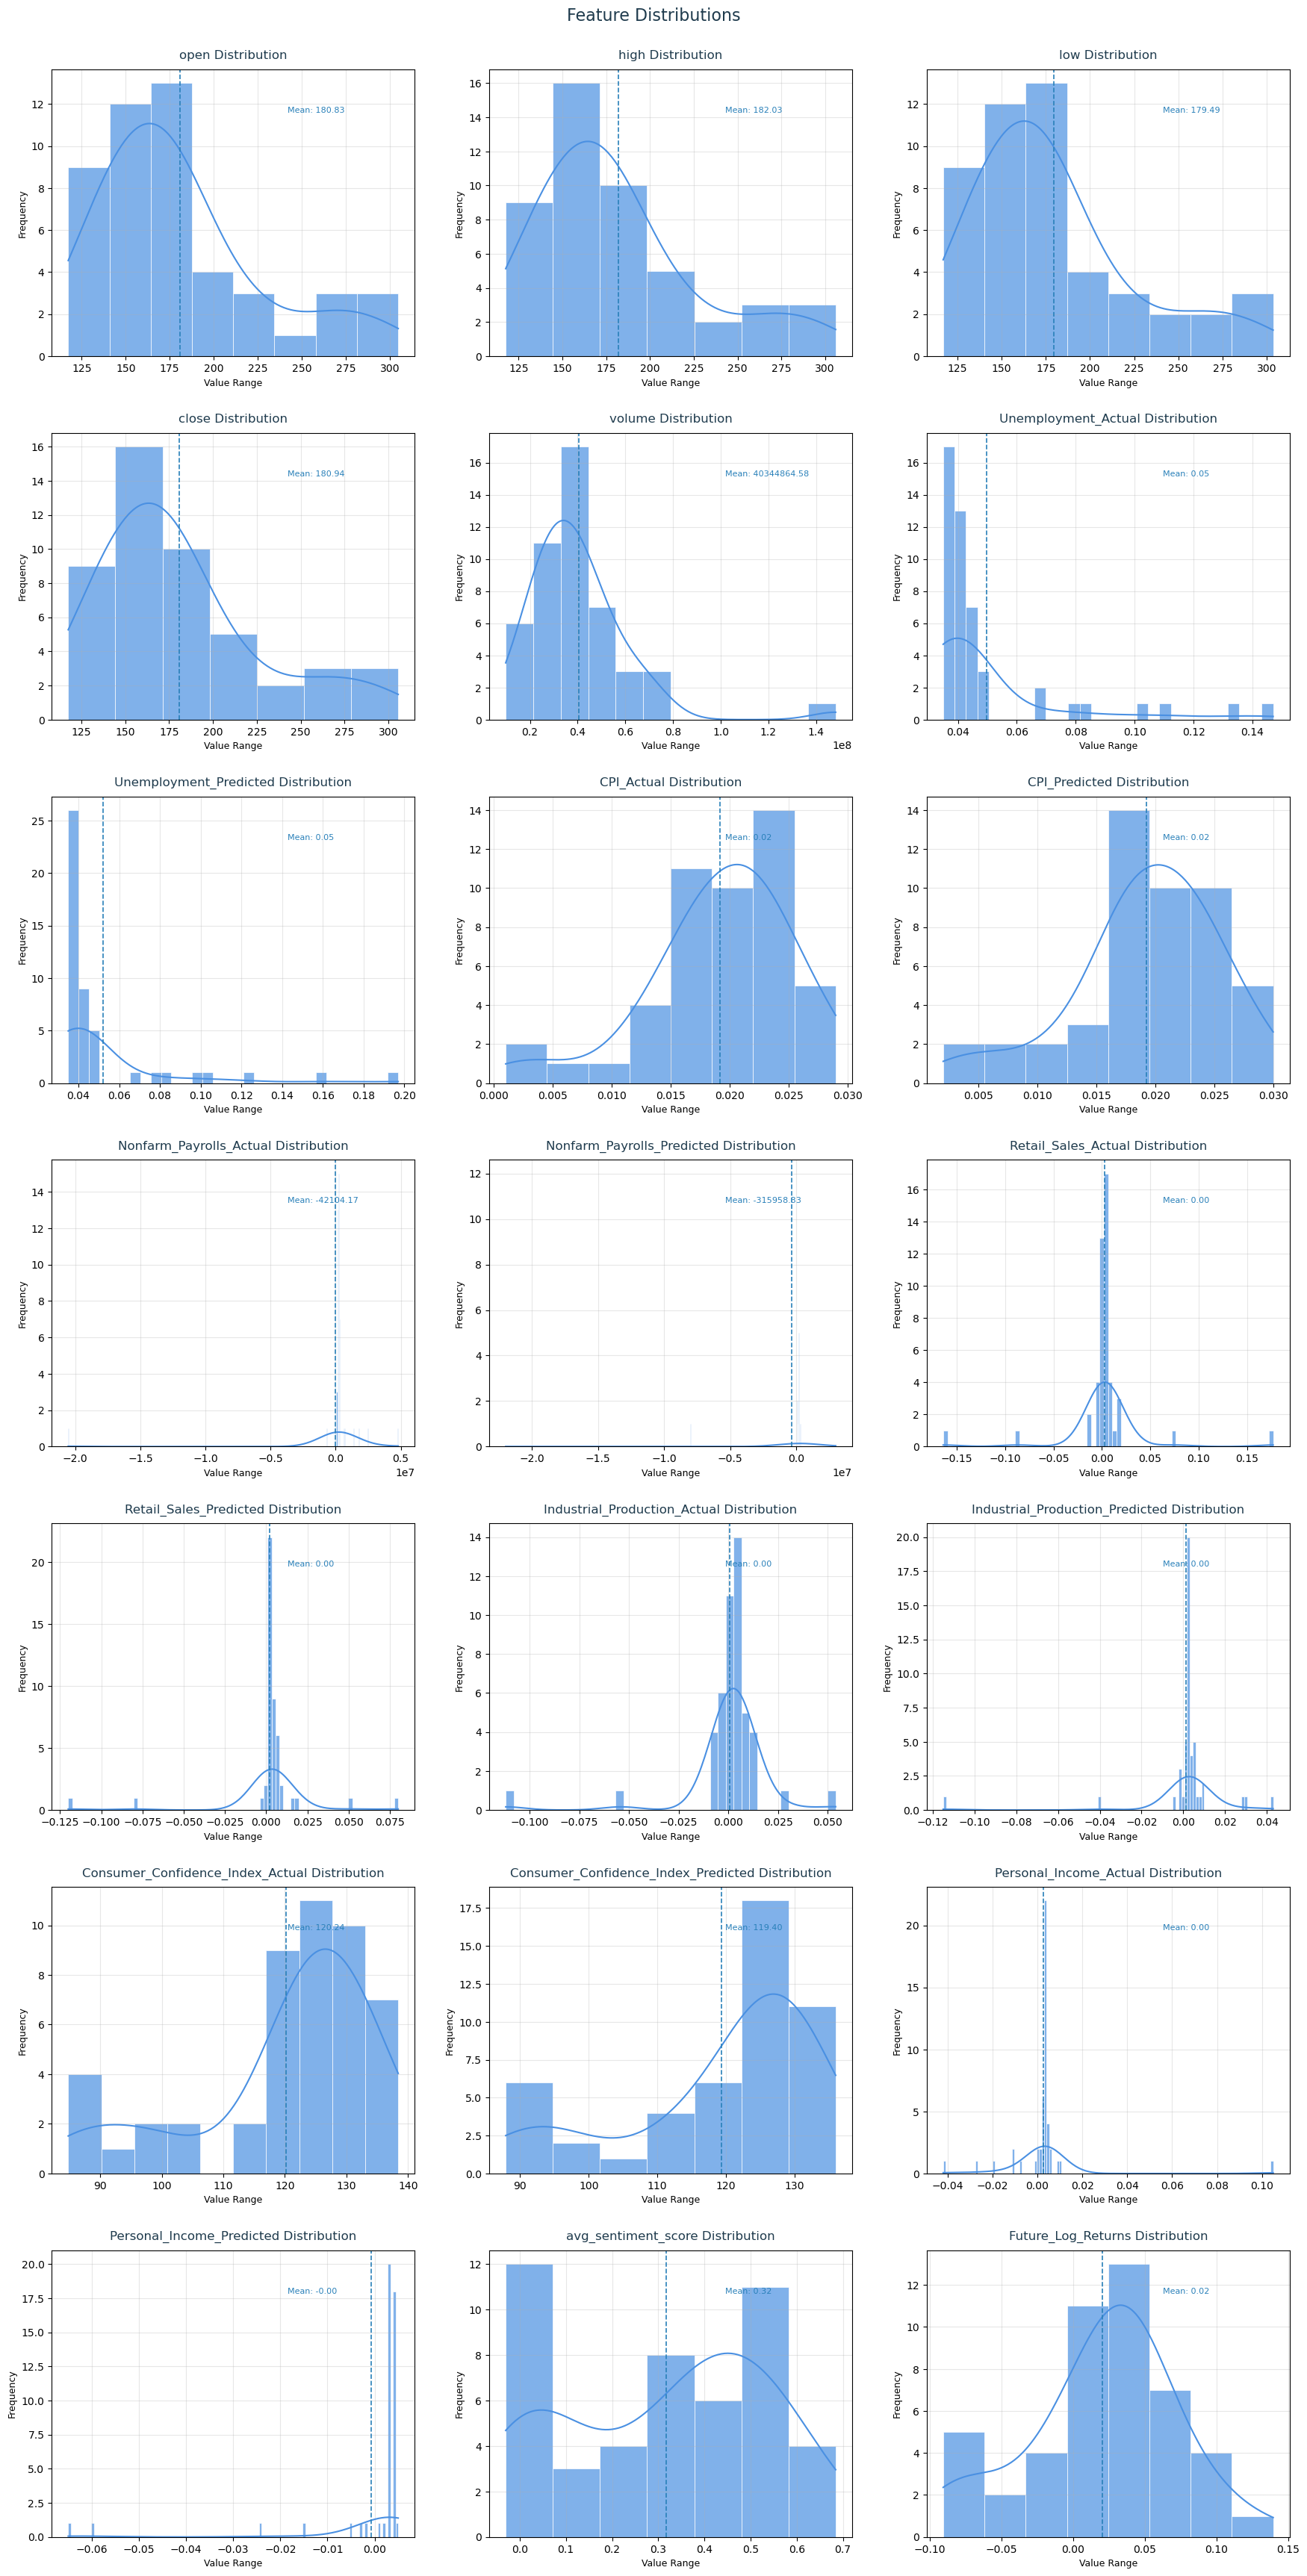

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


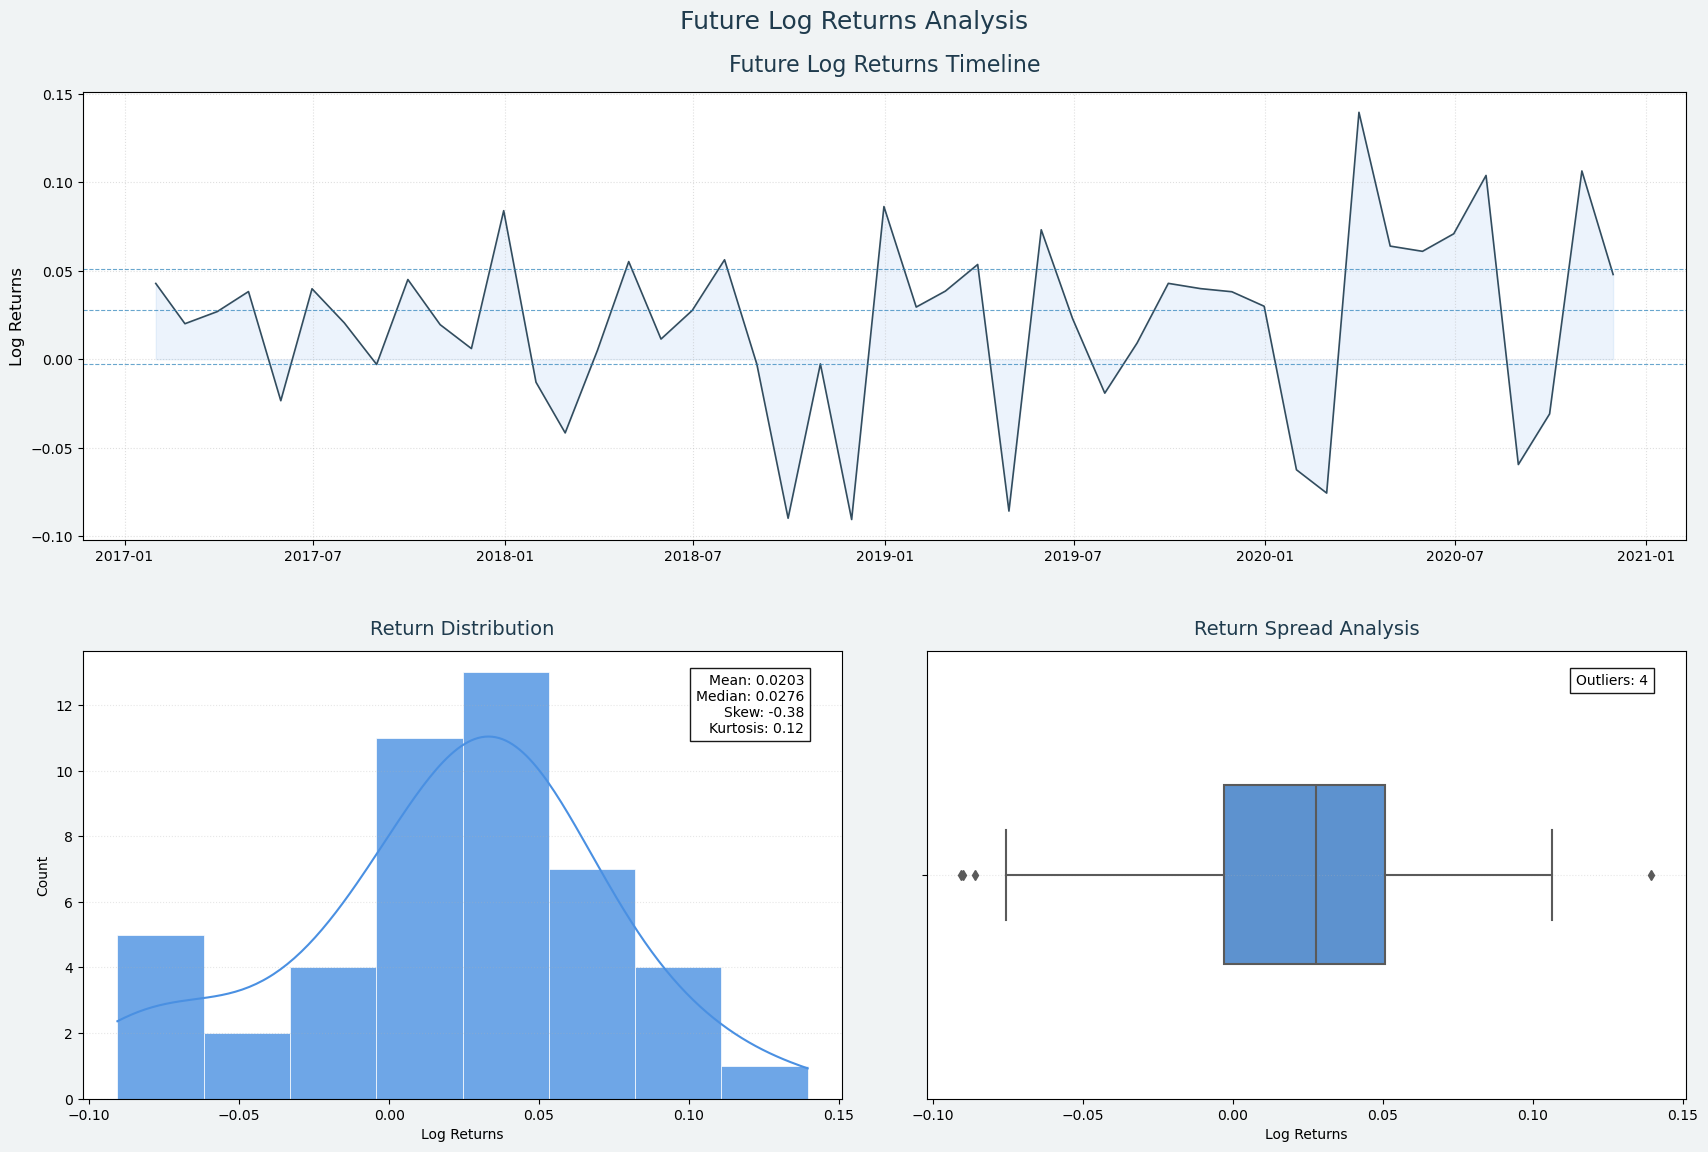

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


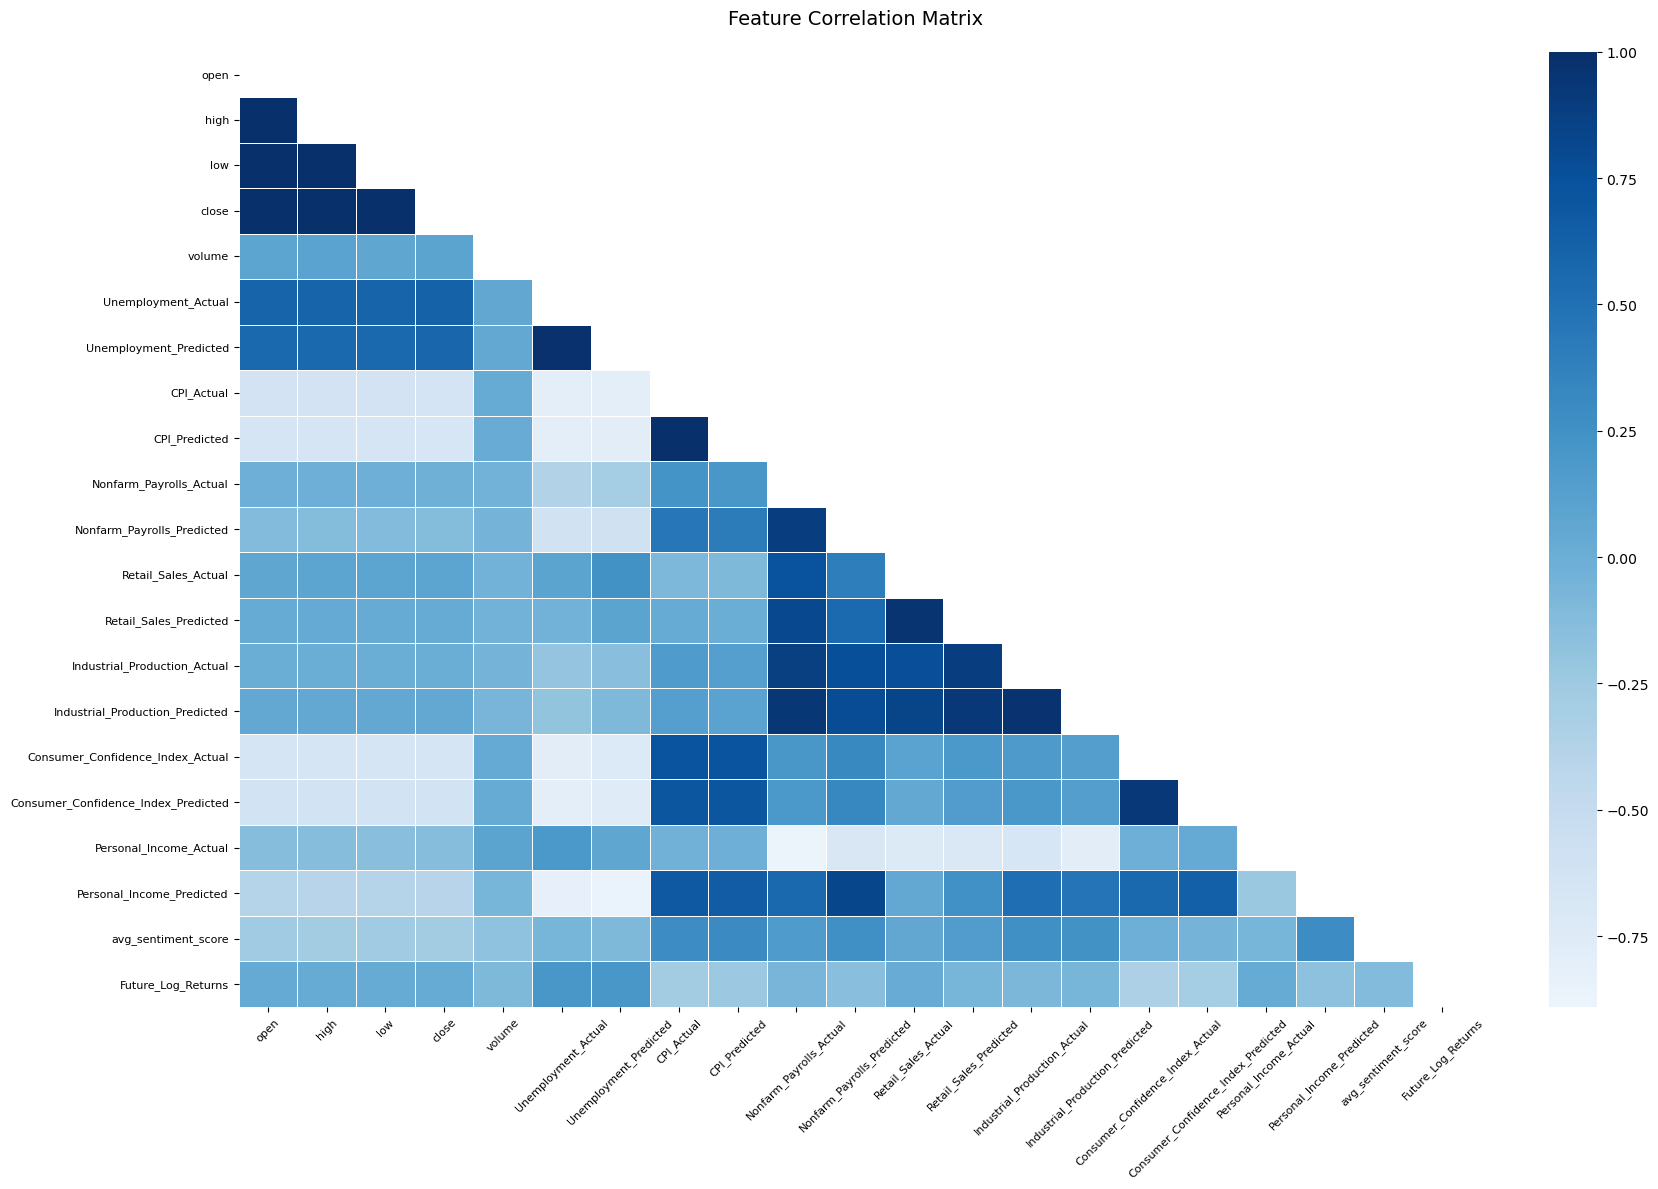

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Boxplot Visualization with Enhanced Styling
numerical_cols = eda_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create dynamic grid layout
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
fig.suptitle("Feature Distribution Analysis", y=0.99, fontsize=18, color='#1f3b4d', weight='semibold')
axes = axes.flatten()

# Custom boxplot styling
boxprops = dict(linestyle='-', linewidth=1.5, color='#4a90e2')
medianprops = dict(linestyle='-', linewidth=2.5, color='#1f3b4d')
whiskerprops = dict(linestyle='--', linewidth=1.2, color='#1f3b4d')
capprops = dict(linewidth=1.5, color='#1f3b4d')
flierprops = dict(marker='o', markersize=4, markerfacecolor='#7f8c8d', alpha=0.5)

for i, col in enumerate(numerical_cols):
    # Create boxplot with custom styling
    sns.boxplot(x=eda_df[col], ax=axes[i], 
                color='#4a90e2',
                boxprops=boxprops,
                medianprops=medianprops,
                whiskerprops=whiskerprops,
                capprops=capprops,
                flierprops=flierprops)
    
    # Add annotations
    q1, med, q3 = eda_df[col].quantile([0.25, 0.5, 0.75])
    axes[i].text(0.95, 0.85, 
                f'Q1: {q1:.2f}\nMed: {med:.2f}\nQ3: {q3:.2f}',
                transform=axes[i].transAxes,
                ha='right', va='top',
                bbox=dict(facecolor='white', alpha=0.9, edgecolor='#bdc3c7'),
                fontsize=9)
    
    # Styling
    axes[i].set_title(f'{col}', fontsize=14, pad=12, color='#1f3b4d', weight='medium')
    axes[i].set_xlabel('')
    axes[i].grid(True, axis='y', linestyle=':', color='gray', alpha=0.4)
    axes[i].set_facecolor('#ecf0f1')
    
    # Remove top and right spines
    for spine in ['top', 'right']:
        axes[i].spines[spine].set_visible(False)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3)
plt.show()

# Enhanced Histogram Visualization

eda_df = eda_df.replace([np.inf, -np.inf], np.nan)

numerical_cols = eda_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create dynamic grid layout
n_cols = 3  # Three columns for better space utilization
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create figure with custom styling
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
fig.suptitle("Feature Distributions", y=0.99, fontsize=16, color='#1f3b4d')
axes = axes.flatten()

# Custom histogram parameters
hist_kwargs = {
    'kde': True,
    'color': '#4a90e2',
    'alpha': 0.7,
    'edgecolor': 'w',
    'linewidth': 0.5,
    'bins': 'auto'
}

for i, col in enumerate(numerical_cols):
    sns.histplot(eda_df[col], ax=axes[i], **hist_kwargs)
    axes[i].set_title(f'{col} Distribution', fontsize=12, pad=10, color='#1f3b4d')
    axes[i].set_xlabel('Value Range', fontsize=9)
    axes[i].set_ylabel('Frequency', fontsize=9)
    axes[i].grid(True, alpha=0.3)
    
    # Add vertical mean line
    mean_val = eda_df[col].mean()
    axes[i].axvline(mean_val, color='#2980b9', linestyle='--', linewidth=1.2)
    axes[i].annotate(f'Mean: {mean_val:.2f}', 
                    xy=(0.65, 0.85), 
                    xycoords='axes fraction',
                    fontsize=8, 
                    color='#2980b9')

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=2.5)
plt.show()

# Create figure with subplots
fig = plt.figure(figsize=(18, 12), facecolor='#f0f3f4')
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])  # Time series
ax2 = fig.add_subplot(gs[1, 0])  # Distribution
ax3 = fig.add_subplot(gs[1, 1])  # Boxplot

# Clean data first
target_series = eda_df['Future_Log_Returns'].replace([np.inf, -np.inf], np.nan).dropna()

# Time Series Plot
# --------------------------
ax1.plot(target_series.index, target_series, 
        color='#1f3b4d', linewidth=1.2, alpha=0.9)
ax1.fill_between(target_series.index, target_series, 
                color='#4a90e2', alpha=0.1)
ax1.set_title('Future Log Returns Timeline', 
            fontsize=16, pad=15, color='#1f3b4d')
ax1.set_ylabel('Log Returns', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.4)

# Add horizontal lines for key levels
for q in [0.25, 0.5, 0.75]:
    quantile_val = target_series.quantile(q)
    ax1.axhline(quantile_val, color='#2980b9', 
               linestyle='--', alpha=0.7, linewidth=0.8)

# Distribution Plot
# --------------------------
sns.histplot(target_series, kde=True, ax=ax2, 
            color='#4a90e2', edgecolor='w',
            linewidth=0.5, alpha=0.8)
ax2.set_title('Return Distribution', fontsize=14, 
            color='#1f3b4d', pad=12)
ax2.set_xlabel('Log Returns', fontsize=10)
ax2.grid(True, axis='y', linestyle=':', alpha=0.3)

# Add distribution stats
stats_text = f"""Mean: {target_series.mean():.4f}
Median: {target_series.median():.4f}
Skew: {target_series.skew():.2f}
Kurtosis: {target_series.kurtosis():.2f}"""
ax2.text(0.95, 0.95, stats_text, 
        transform=ax2.transAxes, ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.9),
        fontsize=10)

# Boxplot
# --------------------------
sns.boxplot(x=target_series, ax=ax3, color='#4a90e2',
           width=0.4, linewidth=1.5)
ax3.set_title('Return Spread Analysis', fontsize=14,
            color='#1f3b4d', pad=12)
ax3.set_xlabel('Log Returns', fontsize=10)
ax3.grid(True, axis='y', linestyle=':', alpha=0.3)

# Add outlier count annotation
q1 = target_series.quantile(0.25)
q3 = target_series.quantile(0.75)
iqr = q3 - q1
outliers = target_series[(target_series < (q1 - 1.5*iqr)) | 
                        (target_series > (q3 + 1.5*iqr))]
ax3.text(0.95, 0.95, f'Outliers: {len(outliers)}',
        transform=ax3.transAxes, ha='right', va='top',
        bbox=dict(facecolor='white', alpha=0.9),
        fontsize=10)

# Final styling
plt.tight_layout(pad=4)
fig.suptitle('Future Log Returns Analysis', 
           y=0.99, fontsize=18, color='#1f3b4d')
plt.show()

# Correlation Analysis
plt.figure(figsize=(18, 12))
corr_matrix = eda_df.corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', 
           center=0, linewidths=0.5, annot_kws={'size': 8})
plt.title('Feature Correlation Matrix', pad=20, fontsize=14)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Feature Construction - Competitors' tickers
-> Financial indicators like the VIX Index or Bitcoin prices provide external context to stock movements. 

-> We define a function to fetch these from Yahoo Finance:

In [34]:
def add_financial_indicators(base_data, start_date, end_date):
    # Define Financial Indicators Configuration inside the function
    financial_tickers = {
        'VIX_Index': '^VIX',
        'Brent_Crude_Oil': 'BZ=F',
        'Tech_Sector_ETF': 'XLK',
        'Bitcoin_Price': 'BTC-USD',
        'Global_Tech_ETF': 'IXN',
        'Intl_Stock_ETF': 'VXUS',
        'Ten_Year_Treasury_Yield': '^TNX',
        'US_Dollar_Index': 'DX-Y.NYB',
        'SP500_Index': '^GSPC',
        'Nasdaq_Volatility_Index': '^VXN',
        'Shanghai_Composite_Index': '000001.SS',
        'Euro_Stoxx_50_Index': '^STOXX50E',
        'Nikkei_225_Index': '^N225',
        'DAX_Index': '^GDAXI',
        'TSX_Composite_Index': '^GSPTSE',
        'IPC_Index': '^MXX',
        'FTSE_100_Index': '^FTSE',
        'CAC_40_Index': '^FCHI',
        'Hang_Seng_Index': '^HSI',
        'BSE_Sensex_Index': '^BSESN',
        'ASX_200_Index': '^AXJO',
        'KOSPI_Index': '^KS11',
        'Bovespa_Index': '^BVSP'
    }
    enriched_data = base_data.copy()
    enriched_data['date'] = pd.to_datetime(enriched_data['date'])
    feature_data = {}
    for name, ticker in financial_tickers.items():
        feature_data[name] = yf.download(ticker, start=start_date, end=end_date)['Close']
    for name in feature_data:
        feature_df = feature_data[name].reset_index().rename(columns={'Date': 'date', 'Close': name})
        feature_df['date'] = pd.to_datetime(feature_df['date'])
        enriched_data = pd.merge(enriched_data, feature_df, on='date', how='left')
    financial_feature_names = list(financial_tickers.keys())
    return enriched_data, financial_feature_names

In [35]:
start = min(stock_macro_news_data.date)
end = max(stock_macro_news_data.date)

enriched_stock_data, financial_feature_names = add_financial_indicators(stock_macro_news_data, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [37]:
display(enriched_stock_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 47 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2333 non-null   datetime64[ns]
 1   open                                 2333 non-null   float64       
 2   high                                 2333 non-null   float64       
 3   low                                  2333 non-null   float64       
 4   close                                2333 non-null   float64       
 5   volume                               2333 non-null   int64         
 6   ticker                               2333 non-null   object        
 7   month_year                           2333 non-null   object        
 8   Release_Date                         2038 non-null   object        
 9   Unemployment_Actual                  2038 non-null   float64       
 10  Unemployment

None

# Feature Construction - Technical Indicators
-> Technical indicators, derived from price and volume, are vital for stock prediction. 

-> We use the ta library

-> Indicators like SMA (Simple Moving Average) and RSI (Relative Strength Index) capture trends and momentum.

In [38]:
def calculate_technical_indicators(daily_data):

    df = daily_data.copy()
    
    # Trend Indicators
    df['SMA_10'] = SMAIndicator(df['close'], window=10).sma_indicator()
    df['SMA_20'] = SMAIndicator(df['close'], window=20).sma_indicator()
    df['SMA_50'] = SMAIndicator(df['close'], window=50).sma_indicator()
    df['EMA_10'] = EMAIndicator(df['close'], window=10).ema_indicator()
    df['EMA_20'] = EMAIndicator(df['close'], window=20).ema_indicator()
    df['EMA_50'] = EMAIndicator(df['close'], window=50).ema_indicator()
    macd = MACD(df['close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_histogram'] = macd.macd_diff()
    
    # Momentum Indicators
    df['RSI_14'] = RSIIndicator(df['close'], window=14).rsi()
    df['RSI_7'] = RSIIndicator(df['close'], window=7).rsi()
    stoch = StochasticOscillator(df['high'], df['low'], df['close'], window=14)
    df['Stoch_%K'] = stoch.stoch()
    df['Stoch_%D'] = stoch.stoch_signal()
    df['ROC_10'] = ROCIndicator(df['close'], window=10).roc()
    df['ROC_21'] = ROCIndicator(df['close'], window=21).roc()
    
    # Volatility Indicators
    bb = BollingerBands(df['close'], window=20)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
    df['ATR_14'] = AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
    df['Std_20'] = df['close'].rolling(window=20).std()
    
    # Volume Indicators
    df['OBV'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    df['CMF_20'] = ChaikinMoneyFlowIndicator(df['high'], df['low'], df['close'], df['volume'], window=20).chaikin_money_flow()
    df['Typical_Price'] = (df['high'] + df['low'] + df['close']) / 3
    df['VWAP_20'] = (df['Typical_Price'] * df['volume']).rolling(window=20).sum() / df['volume'].rolling(window=20).sum()
    
    return df

In [40]:
stock_with_indicators = calculate_technical_indicators(enriched_stock_data)
display(stock_with_indicators.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 71 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2333 non-null   datetime64[ns]
 1   open                                 2333 non-null   float64       
 2   high                                 2333 non-null   float64       
 3   low                                  2333 non-null   float64       
 4   close                                2333 non-null   float64       
 5   volume                               2333 non-null   int64         
 6   ticker                               2333 non-null   object        
 7   month_year                           2333 non-null   object        
 8   Release_Date                         2038 non-null   object        
 9   Unemployment_Actual                  2038 non-null   float64       
 10  Unemployment

None

# Feature Construction - Macroeconomic Features

-> Macroeconomic data (e.g., Unemployment Rate) influences markets. We calculate errors between actual and predicted values

-> The error terms (e.g., Unemployment_error) highlight discrepancies that may predict market reactions.

In [24]:
# Define Macroeconomic Feature Names
macro_feature_names = [
    'Unemployment_Actual', 'Unemployment_Predicted',
    'CPI_Actual', 'CPI_Predicted',
    'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted',
    'Retail_Sales_Actual', 'Retail_Sales_Predicted',
    'Industrial_Production_Actual', 'Industrial_Production_Predicted',
    'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted',
    'Personal_Income_Actual', 'Personal_Income_Predicted'
]

# Function to Add Macroeconomic Errors
def add_macro_errors(data, feature_names):
    df = data.copy()
    for i in range(0, len(feature_names), 2):
        actual, predicted = feature_names[i], feature_names[i + 1]
        indicator = actual.split('_')[0]
        df[f"{indicator}_error"] = df[actual] - df[predicted]
    return df

In [26]:
stock_with_indicators = add_macro_errors(stock_with_indicators, macro_feature_names)
display(stock_with_indicators.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 67 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 2333 non-null   datetime64[ns]
 1   open                                 2333 non-null   float64       
 2   high                                 2333 non-null   float64       
 3   low                                  2333 non-null   float64       
 4   close                                2333 non-null   float64       
 5   volume                               2333 non-null   int64         
 6   ticker                               2333 non-null   object        
 7   month_year                           2333 non-null   object        
 8   Release_Date                         2038 non-null   object        
 9   Unemployment_Actual                  2038 non-null   float64       
 10  Unemployment

None

# Feature Construction - Lagged Features

-> In time series, past values inform the future. We add lagged features

-> Lagged features like close_lag10 capture temporal dependencies

In [27]:
# def add_lagged_features(df, lags=[1, 10, 42, 63], columns=None):
#     df.sort_values('date', inplace=True)
#     if columns is None:
#         columns = df.select_dtypes(include=[np.number]).columns.tolist()
#     for col in columns:
#         for lag in lags:
#             df[f'{col}_lag{lag}'] = df[col].shift(lag)
#     return df

In [44]:
def add_lagged_features(df, lags=[1, 10, 42, 63], columns=None):
    df_sorted = df.sort_values('date').copy()
    if columns is None:
        columns = df_sorted.select_dtypes(include=[np.number]).columns.tolist()
    lagged_dfs = []
    for col in columns:
        for lag in lags:
            lagged_series = df_sorted[col].shift(lag).rename(f'{col}_lag{lag}')
            lagged_dfs.append(lagged_series)
    if lagged_dfs:
        lagged_df = pd.concat(lagged_dfs, axis=1)
        df_sorted = pd.concat([df_sorted, lagged_df], axis=1)
    return df_sorted

In [112]:
columns_to_lag = ['open', 'high', 'low', 'close', 'volume', '^VIX', 'BZ=F', 'XLK', 'BTC-USD','IXN', 'VXUS', '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS','^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI','^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP']
stock_data_with_lag = add_lagged_features(stock_with_indicators, columns=columns_to_lag)
display(stock_data_with_lag.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Columns: 295 entries, date to ^BVSP_lag63
dtypes: datetime64[ns](1), float64(288), int64(2), object(4)
memory usage: 5.3+ MB


None

# Feature Construction - Sentiment Analysis
-> News sentiment can sway stock prices. We use VADER to analyze titles

-> The sentiment_score quantifies news positivity or negativity.

In [113]:
nlp = spacy.load('en_core_web_sm')

In [114]:
def clean_title(df, nlp, top_n=10):
    
    # Step 1: Handle missing values in 'titles'
    df['titles'] = df['titles'].fillna('')  # Replace NaN/None with an empty string
    
    # Step 2: Lowercase the titles
    df['preprocessed'] = df['titles'].str.lower()
    
    # Step 3: Process with spaCy - lemmatize and remove stop words
    texts = df['preprocessed'].tolist()
    processed_docs = list(nlp.pipe(texts))
    df['processed_title'] = [' '.join([token.lemma_ for token in doc if not token.is_stop]) for doc in processed_docs]
    
    # Step 4: Clean up the processed title
    df['processed_title'] = df['processed_title'].astype(str).str.rstrip()
    df['processed_title'] = df['processed_title'].apply(lambda x: x + '.' if x and not x.endswith('.') else x)
    
    # Step 5: Drop the temporary 'preprocessed' column
    df.drop(columns=['preprocessed'], inplace=True)
    
    # Step 6: Define tokenization function
    def tokenize(text):
        return re.findall(r'\w+|\.', text)
    
    # Step 7: Tokenize and calculate word frequencies
    all_tokens = []
    for title in df['processed_title'].dropna():
        all_tokens.extend(tokenize(title))
    
    word_tokens = [token for token in all_tokens if token.isalnum()]
    word_freq = Counter(word_tokens)
    unique_words = len(word_freq)
    N = int(0.01 * unique_words)
    high_freq_words = set(word for word, freq in word_freq.most_common(N))
    
    # Step 8: Define filtering function for high-frequency words
    def filter_text(text):
        tokens = tokenize(text)
        filtered_tokens = [token for token in tokens if not (token.isalnum() and token in high_freq_words)]
        return ' '.join(filtered_tokens)
    
    # Step 9: Apply filtering to create 'filtered_title'
    df['filtered_title'] = df['processed_title'].apply(filter_text)
    
    # Step 10: Plotting before and after filtering
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Before removal plot
    all_text_before = ' '.join(df['processed_title'].dropna())
    words_before = re.findall(r'\w+', all_text_before)
    word_freq_before = Counter(words_before)
    top_words_before = word_freq_before.most_common(top_n)
    df_before = pd.DataFrame(top_words_before, columns=['word', 'frequency'])
    df_before['stage'] = 'before'
    
    axes[0].bar(df_before['word'], df_before['frequency'], color='steelblue', edgecolor='black', linewidth=0.5)
    axes[0].set_title("Top 10 Words Before Removal")
    axes[0].set_xlabel("Words")
    axes[0].set_ylabel("Frequency")
    axes[0].tick_params(axis='x', rotation=45)
    
    # After removal plot
    all_text_after = ' '.join(df['filtered_title'].dropna())
    words_after = re.findall(r'\w+', all_text_after)
    word_freq_after = Counter(words_after)
    top_words_after = word_freq_after.most_common(top_n)
    df_after = pd.DataFrame(top_words_after, columns=['word', 'frequency'])
    df_after['stage'] = 'after'
    
    axes[1].bar(df_after['word'], df_after['frequency'], color='steelblue', hatch='/', edgecolor='black', linewidth=0.5)
    axes[1].set_title("Top 10 Words After Removal")
    axes[1].set_xlabel("Words")
    axes[1].set_ylabel("Frequency")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Step 11: Print sample before and after filtering
    print("First 5 Texts Before and After High-Frequency Word Removal:")
    print("-" * 60)
    sample_df = df[['titles', 'filtered_title']].head(5)  # Changed 'new_df' to 'df'
    for idx, row in sample_df.iterrows():
        print(f"Original: {row['titles']}")
        print(f"Filtered: {row['filtered_title']}")
        print("-" * 60)
    
    # Step 12: Drop the 'processed_title' and 'titles' columns
    df.drop(columns=['processed_title', 'titles'], inplace=True)
    
    # Step 13: Rename 'filtered_title' to 'titles'
    df = df.rename(columns={"filtered_title": "titles"})
    
    return df

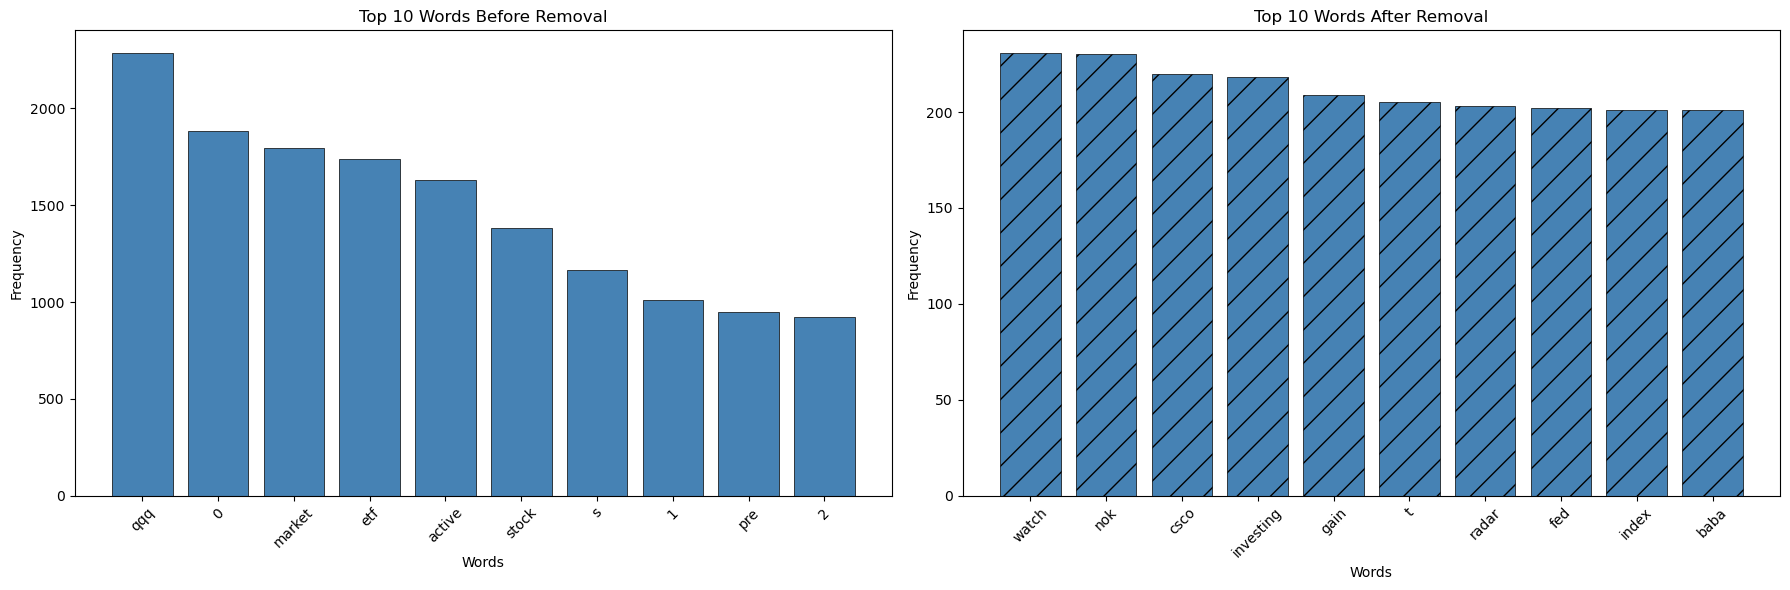

First 5 Texts Before and After High-Frequency Word Removal:
------------------------------------------------------------
Original: After Hours Most Active for Jan 4, 2016 : WSH, TW, FOSL, EPD, ACAS, QQQ, AAPL, T, XOM, F, BYD, ARRS, China's Circuit Breakers Thrown, Market Mayhem: World ETFs Crumble In China Aftershock
Filtered: jan wsh tw fosl epd acas t xom byd arrs china circuit breaker throw mayhem world crumble china aftershock .
------------------------------------------------------------
Original: After Hours Most Active for Jan 5, 2016 : FIG, MDLZ, ARRS, QQQ, KO, HLF, FCX, F, STOR, MU, MSFT, AAPL, ETF Preview: Broad Market ETFs Decline In Line With Futures Amid N.Korea H-Bomb Claims, Kimble Charting: Double Top In NASDAQ With Momentum Back At 2,000?, Pre-Market Most Active for Jan 5, 2016 : ARRS, TVIX, XIV, QQQ, SUNE, BP, SQQQ, FCS, BAC, BIN, FCAU, NVS, Small Cap Growth and China: 2 ETFs to Watch on Outsized Volume
Filtered: jan fig mdlz arrs ko hlf fcx stor broad decline line am

In [115]:
cleaned_df = clean_title(stock_data_with_lag, nlp)

In [116]:
sia = SentimentIntensityAnalyzer()
cleaned_df['sentiment_score'] = cleaned_df['titles'].apply(
    lambda x: sia.polarity_scores(x)['compound'] if pd.notnull(x) else 0
)

In [117]:
cleaned_df['sentiment_score']

0       0.0000
1      -0.4939
2      -0.3182
3       0.9337
4       0.8176
         ...  
2328    0.0000
2329    0.0000
2330   -0.9612
2331    0.7430
2332   -0.8934
Name: sentiment_score, Length: 2333, dtype: float64

# Handling Missing Values
-> Missing data can skew models. We visualize and address it:

-> Filling with 0 assumes no impact when data is absent, a common strategy for financial indicators.

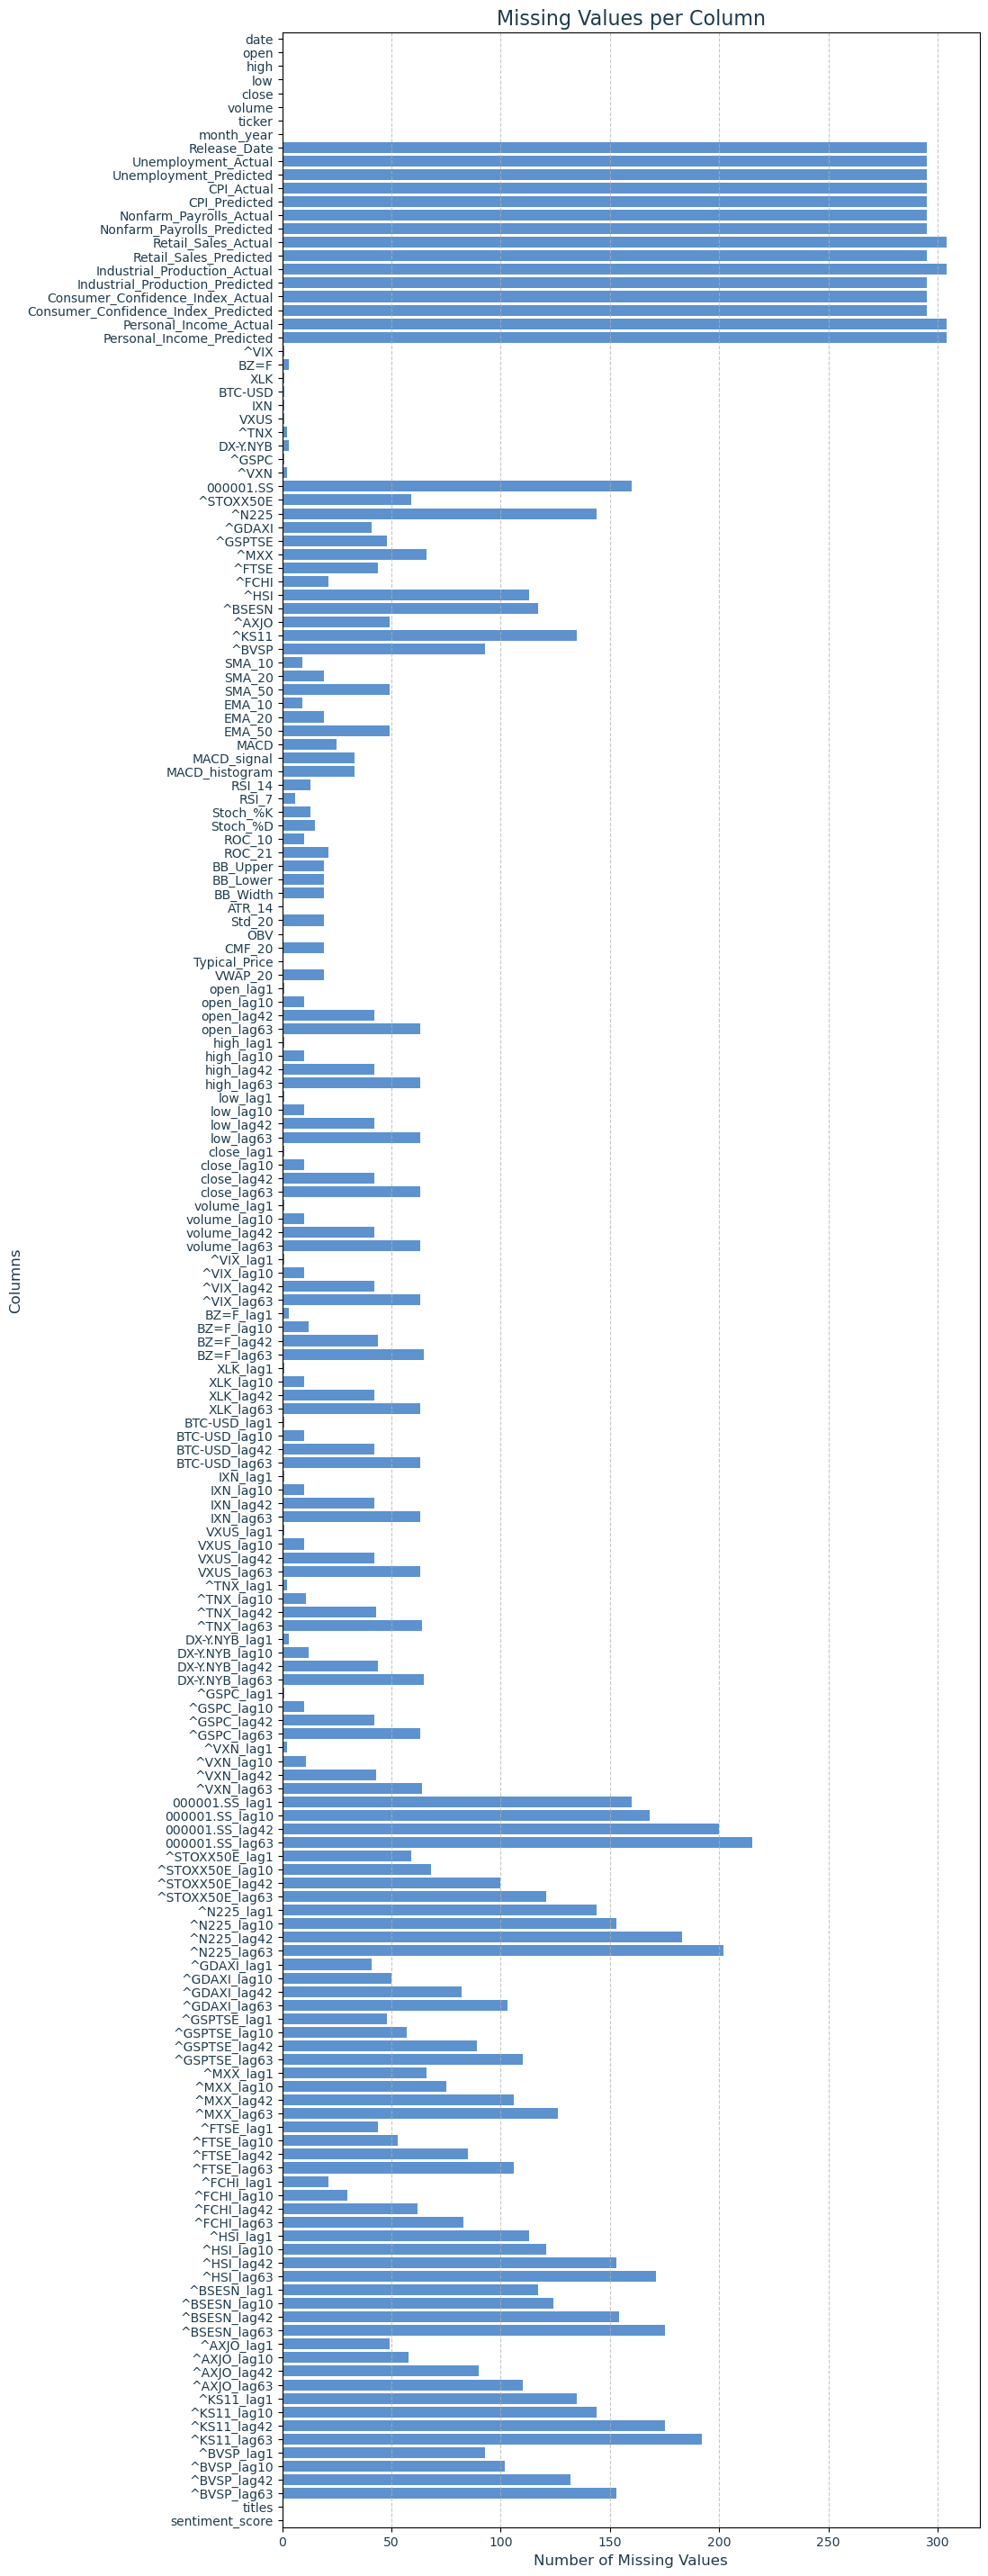

In [225]:
# Calculate missing data
missing_data = cleaned_df.isnull().sum()

# Create the bar plot
plt.figure(figsize=(10, 36))
sns.barplot(y=missing_data.index, x=missing_data.values, color='#4a90e2')  # Set the color to a blue shade
plt.title('Missing Values per Column', fontsize=16, color='#1f3b4d')  # Set the title color
plt.xlabel('Number of Missing Values', fontsize=12, color='#1f3b4d')  # Set the x-label color
plt.ylabel('Columns', fontsize=12, color='#1f3b4d')  # Set the y-label color
plt.xticks(color='#1f3b4d')  # Set the x-ticks color
plt.yticks(color='#1f3b4d')  # Set the y-ticks color
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()

In [226]:
def process_data(cleaned_df, start='2017-01-01', end='2021-01-01'):
    nltk.download('vader_lexicon', quiet=True)
    sid = SentimentIntensityAnalyzer()
    result = cleaned_df.copy()
    result['sentiment_score'] = result['titles'].apply(
        lambda x: sid.polarity_scores(str(x))['compound']
    )
    if 'month_year' not in result.columns:
        result['month_year'] = pd.to_datetime(result['date']).dt.to_period('M')
    result = result.groupby('month_year').agg({
        'titles': lambda x: ' '.join(x.dropna()),
        'sentiment_score': 'mean'
    }).reset_index()
    result.rename(columns={'sentiment_score': 'avg_sentiment_score'}, inplace=True)
    final_df = pd.merge(cleaned_df, result, how='left', on=['month_year'])
    final_df['date'] = pd.to_datetime(final_df['date'])
    final_df.set_index('date', inplace=True)
    final_df = final_df.loc[start:end]
    final_df.drop(['ticker', 'Release_Date', 'titles_x', 'sentiment_score'], axis=1, inplace=True, errors='ignore')
    final_df = final_df.resample('M').last()
    return final_df

In [227]:
final_df = process_data(cleaned_df, start='2017-01-01', end='2021-01-01')

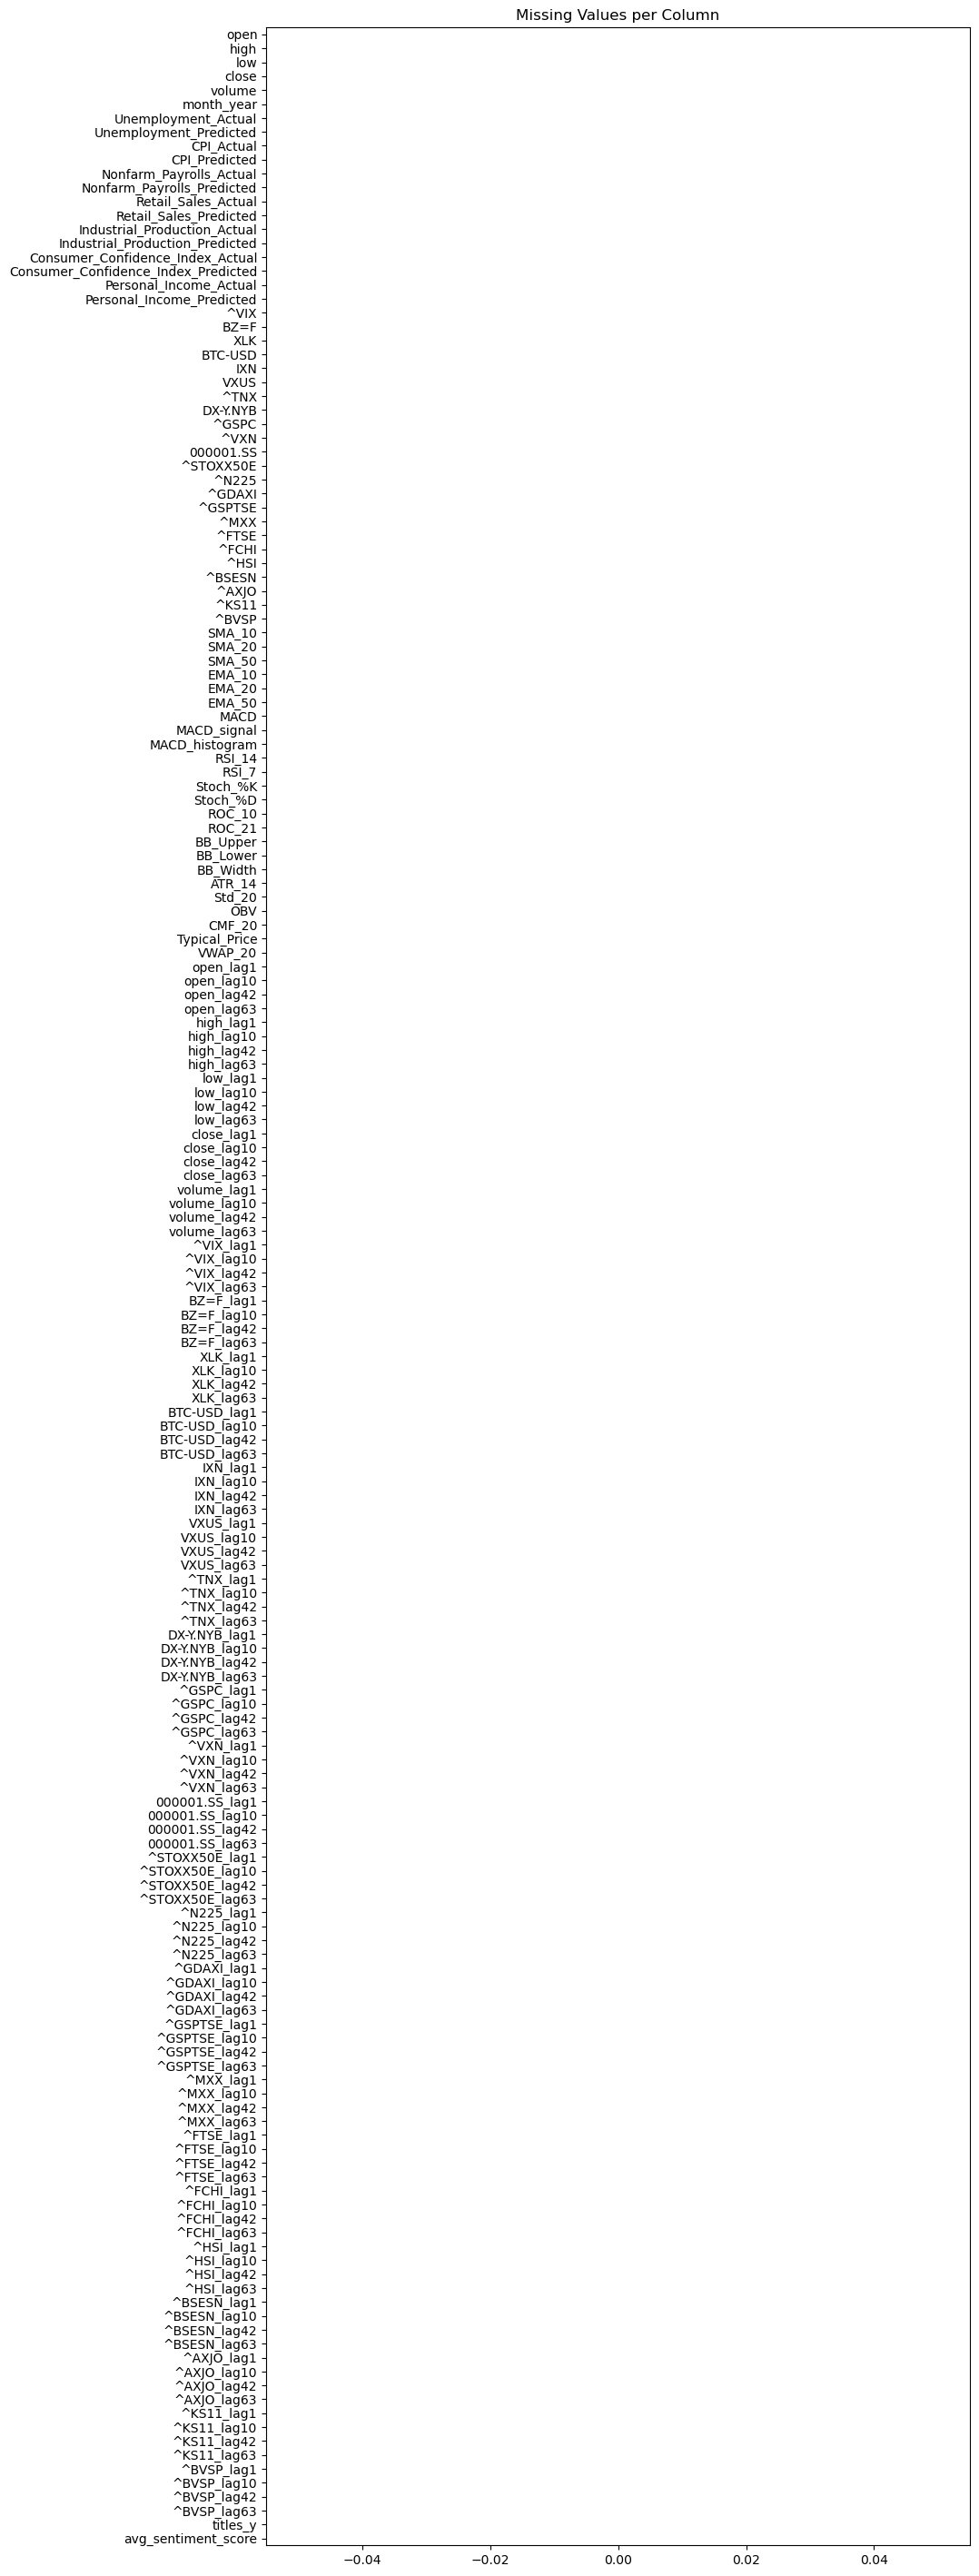

In [228]:
missing_data = final_df.isnull().sum()
plt.figure(figsize=(10, 36))
sns.barplot(y=missing_data.index, x=missing_data.values)
plt.title('Missing Values per Column')
plt.show()

# OOP - combine everythings

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import yfinance as yf
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
from ta.trend import MACD, EMAIndicator, SMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

class StockFeaturePipeline:
    def __init__(self, db_path):
        self.db_path = db_path
        self.nlp = spacy.load('en_core_web_sm')
        self.ticker_fallbacks = {
            '^VIX': 'VIX',
            'DX-Y.NYB': 'UUP',
            '000001.SS': '600036.SS',
        }
        self.financial_tickers = [
            '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX',
            'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225',
            '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN',
            '^AXJO', '^KS11', '^BVSP'
        ]
        
        self.macro_features = [
            'Unemployment_Actual', 'Unemployment_Predicted',
            'CPI_Actual', 'CPI_Predicted',
            'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted',
            'Retail_Sales_Actual', 'Retail_Sales_Predicted',
            'Industrial_Production_Actual', 'Industrial_Production_Predicted',
            'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted',
            'Personal_Income_Actual', 'Personal_Income_Predicted'
        ]
        
        self.columns_to_lag = [
            'open', 'high', 'low', 'close', 'volume',
            '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS',
            '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS',
            '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX',
            '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP'
        ]

    def add_target(self, df):
        df["Future_Log_Returns"] = np.log(df['close']).diff(1).shift(-1)
        return df

    class DataLoader:
        def __init__(self, db_path):
            self.db_path = db_path
            
        def load_data(self):
            conn = sqlite3.connect(self.db_path)
            query = """
            SELECT 
                s.date, s.open, s.high, s.low, s.close, s.volume, s.ticker, s.month_year,
                m.Release_Date, m.Unemployment_Actual, m.Unemployment_Predicted,
                m.CPI_Actual, m.CPI_Predicted, m.Nonfarm_Payrolls_Actual, m.Nonfarm_Payrolls_Predicted,
                m.Retail_Sales_Actual, m.Retail_Sales_Predicted, m.Industrial_Production_Actual,
                m.Industrial_Production_Predicted, m.Consumer_Confidence_Index_Actual,
                m.Consumer_Confidence_Index_Predicted, m.Personal_Income_Actual, m.Personal_Income_Predicted,
                n.titles
            FROM stock_data s
            LEFT JOIN macro_data m ON s.month_year = m.month_year
            LEFT JOIN (
                SELECT date, GROUP_CONCAT(title, ', ') AS titles, month_year, ticker
                FROM news_data
                GROUP BY date, month_year, ticker
            ) n ON s.date = n.date AND s.ticker = n.ticker
            """
            df = pd.read_sql(query, conn)
            conn.close()
            return df

    class FinancialFeatureEngineer:
        def __init__(self, tickers, fallbacks):
            self.tickers = tickers
            self.fallbacks = fallbacks
            
        def add_features(self, df, start_date, end_date):
            df = df.copy()
            df['date'] = pd.to_datetime(df['date'])
            
            for ticker in self.tickers:
                try:
                    data = yf.download(ticker, start=start_date, end=end_date)['Close']
                    if data.empty:
                        data = yf.download(self.fallbacks.get(ticker, ticker), 
                                         start=start_date, end=end_date)['Close']
                        
                    feature_df = data.reset_index().rename(columns={'Date': 'date', 'Close': ticker})
                    feature_df['date'] = pd.to_datetime(feature_df['date'])
                    df = pd.merge(df, feature_df, on='date', how='left')
                    
                    if df[ticker].isnull().all():
                        print(f"Warning: Failed to load data for {ticker}")
                        
                except Exception as e:
                    print(f"Error downloading {ticker}: {str(e)}")
                    df[ticker] = np.nan
                    
            return df

    class TechnicalFeatureEngineer:
        @staticmethod
        def add_features(df):
            df = df.copy()
            
            # Trend Indicators
            df['SMA_10'] = SMAIndicator(df['close'], 10).sma_indicator()
            df['SMA_20'] = SMAIndicator(df['close'], 20).sma_indicator()
            df['SMA_50'] = SMAIndicator(df['close'], 50).sma_indicator()
            df['EMA_10'] = EMAIndicator(df['close'], 10).ema_indicator()
            df['EMA_20'] = EMAIndicator(df['close'], 20).ema_indicator()
            df['EMA_50'] = EMAIndicator(df['close'], 50).ema_indicator()
            
            macd = MACD(df['close'])
            df['MACD'] = macd.macd()
            df['MACD_signal'] = macd.macd_signal()
            df['MACD_histogram'] = macd.macd_diff()
            
            # Momentum Indicators
            df['RSI_14'] = RSIIndicator(df['close'], 14).rsi()
            df['RSI_7'] = RSIIndicator(df['close'], 7).rsi()
            
            stoch = StochasticOscillator(df['high'], df['low'], df['close'], 14)
            df['Stoch_%K'] = stoch.stoch()
            df['Stoch_%D'] = stoch.stoch_signal()
            
            df['ROC_10'] = ROCIndicator(df['close'], 10).roc()
            df['ROC_21'] = ROCIndicator(df['close'], 21).roc()
                
            # Volatility Indicators
            bb = BollingerBands(df['close'], 20)
            df['BB_Upper'] = bb.bollinger_hband()
            df['BB_Lower'] = bb.bollinger_lband()
            df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
            
            df['ATR_14'] = AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
            df['Std_20'] = df['close'].rolling(20).std()
            
            # Volume Indicators
            df['OBV'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
            df['CMF_20'] = ChaikinMoneyFlowIndicator(df['high'], df['low'], df['close'], df['volume'], 20).chaikin_money_flow()
            
            df['Typical_Price'] = (df['high'] + df['low'] + df['close']) / 3
            df['VWAP_20'] = (df['Typical_Price'] * df['volume']).rolling(20).sum() / df['volume'].rolling(20).sum()
            
            return df

    class MacroFeatureEngineer:
        @staticmethod
        def add_errors(df, macro_features):
            df = df.copy()
            for i in range(0, len(macro_features), 2):
                actual, pred = macro_features[i], macro_features[i+1]
                indicator = actual.split('_')[0]
                error_col = f"{indicator}_error"
                if actual in df.columns and pred in df.columns:
                    df[error_col] = df[actual] - df[pred]
                else:
                    print(f"Warning: Missing columns for {error_col} calculation")
                    df[error_col] = np.nan
            return df

    class LagFeatureEngineer:
        @staticmethod
        def add_lags(df, columns, lags):
            sorted_df = df.sort_values('date').copy()
            valid_columns = [col for col in columns if col in sorted_df.columns]
            missing = set(columns) - set(valid_columns)
            
            if missing:
                print(f"Missing columns for lagging: {', '.join(missing)}")
                print("Available columns:", list(sorted_df.columns))
    
            lagged_features = {}
            for col in valid_columns:
                if sorted_df[col].isnull().all():
                    print(f"Skipping lagging for empty column: {col}")
                    continue
                for lag in lags:
                    new_col = f'{col}_lag{lag}'
                    lagged_features[new_col] = sorted_df[col].shift(lag)
    
            if lagged_features:
                lagged_df = pd.DataFrame(lagged_features)
                return pd.concat([sorted_df, lagged_df], axis=1)
            return sorted_df

    class NLPProcessor:
        def __init__(self, nlp):
            self.nlp = nlp
            self.top_n = 10
            
        def process_text(self, df):
            df = df.copy()
            df['titles'] = df['titles'].fillna('')
            df['preprocessed'] = df['titles'].str.lower()
            texts = df['preprocessed'].tolist()
            processed_docs = list(self.nlp.pipe(texts))
            df['processed_title'] = [
                ' '.join([token.lemma_ for token in doc if not token.is_stop])
                for doc in processed_docs
            ]
            df['processed_title'] = df['processed_title'].str.rstrip()
            df['processed_title'] = df['processed_title'].apply(
                lambda x: x + '.' if x and not x.endswith('.') else x
            )
            all_tokens = []
            for title in df['processed_title'].dropna():
                all_tokens.extend(re.findall(r'\w+|\.', title))
            word_tokens = [token for token in all_tokens if token.isalnum()]
            word_freq = Counter(word_tokens)
            unique_words = len(word_freq)
            N = max(1, int(0.01 * unique_words))
            high_freq_words = set(word for word, freq in word_freq.most_common(N))
            
            def filter_text(text):
                tokens = re.findall(r'\w+|\.', text)
                return ' '.join([
                    token for token in tokens
                    if not (token.isalnum() and token in high_freq_words)
                ])
            
            df['filtered_title'] = df['processed_title'].apply(filter_text)
            self._plot_word_frequencies(df)
            self._print_sample_comparison(df)
            df = df.drop(columns=['preprocessed', 'processed_title', 'titles'])
            return df.rename(columns={"filtered_title": "titles"})
        
        def _plot_word_frequencies(self, df):
            fig, axes = plt.subplots(1, 2, figsize=(18, 6))
            all_text_before = ' '.join(df['processed_title'].dropna())
            words_before = re.findall(r'\w+', all_text_before)
            top_words_before = Counter(words_before).most_common(self.top_n)
            axes[0].bar(
                [w[0] for w in top_words_before],
                [w[1] for w in top_words_before],
                color='steelblue',
                edgecolor='black'
            )
            axes[0].set_title("Top Words Before Filtering")
            all_text_after = ' '.join(df['filtered_title'].dropna())
            words_after = re.findall(r'\w+', all_text_after)
            top_words_after = Counter(words_after).most_common(self.top_n)
            axes[1].bar(
                [w[0] for w in top_words_after],
                [w[1] for w in top_words_after],
                color='steelblue',
                hatch='/',
                edgecolor='black'
            )
            axes[1].set_title("Top Words After Filtering")
            plt.tight_layout()
            plt.savefig('word_frequency_comparison.png')
            plt.close()
        
        def _print_sample_comparison(self, df):
            pass

    class SentimentAnalyzer:
        def __init__(self):
            nltk.download('vader_lexicon', quiet=True)
            self.analyzer = SentimentIntensityAnalyzer()
            
        def add_sentiment(self, df):
            df = df.copy()
            df['sentiment_score'] = df['titles'].apply(
                lambda x: self.analyzer.polarity_scores(str(x))['compound']
            )
            return df

    class DataProcessor:
        def process_final(self, df, start_date, end_date):
            df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
            sentiment_df = df.groupby('month_year').agg({
                'titles': lambda x: ' '.join(x.dropna()),
                'sentiment_score': 'mean'
            }).reset_index().rename(columns={'sentiment_score': 'avg_sentiment_score'})
            final_df = pd.merge(
                df,
                sentiment_df,
                on='month_year',
                how='left',
                suffixes=('', '_agg')
            )
            final_df['date'] = pd.to_datetime(final_df['date'])
            final_df.set_index('date', inplace=True)
            final_df = final_df.loc[start_date:end_date]
            cols_to_drop = ['ticker', 'Release_Date', 'titles', 'sentiment_score']
            final_df = final_df.drop(
                columns=[c for c in cols_to_drop if c in final_df.columns]
            )
            return final_df.resample('M').last().dropna(how='all')

    def run_pipeline(self, start_date, end_date):
        loader = self.DataLoader(self.db_path)
        financial_engineer = self.FinancialFeatureEngineer(
            self.financial_tickers,
            self.ticker_fallbacks
        )
        technical_engineer = self.TechnicalFeatureEngineer()
        macro_engineer = self.MacroFeatureEngineer()
        lag_engineer = self.LagFeatureEngineer()
        nlp_processor = self.NLPProcessor(self.nlp)
        sentiment_analyzer = self.SentimentAnalyzer()
        data_processor = self.DataProcessor()

        df = loader.load_data()
        df = financial_engineer.add_features(df, start_date, end_date)
        df = technical_engineer.add_features(df)
        df = macro_engineer.add_errors(df, self.macro_features)
        df = lag_engineer.add_lags(df, self.columns_to_lag, [1, 10, 42, 63])
        df = nlp_processor.process_text(df)
        df = sentiment_analyzer.add_sentiment(df)
        final_df = data_processor.process_final(df, start_date, end_date)
        final_df = self.add_target(final_df)  # Integrate the target feature here
        
        print("\nFinal DataFrame Info:")
        print(final_df.info())
        
        return final_df

In [4]:
pipeline = StockFeaturePipeline('/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite')
data = pipeline.run_pipeline('2017-01-01', '2021-01-01')
print("\nPipeline completed successfully!")
print(f"Final DataFrame shape: {data.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Columns: 189 entries, open to Future_Log_Returns
dtypes: float64(185), int64(2), object(1), period[M](1)
memory usage: 71.2+ KB
None

Pipeline completed successfully!
Final DataFrame shape: (48, 189)


In [5]:
import sqlite3
import pandas as pd
import numpy as np
import yfinance as yf
import spacy
import re
import matplotlib.pyplot as plt
from collections import Counter
from ta.trend import MACD, EMAIndicator, SMAIndicator
from ta.momentum import RSIIndicator, StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, ChaikinMoneyFlowIndicator
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

class StockFeaturePipeline:
    def __init__(self, db_path):
        self.db_path = db_path
        self.nlp = spacy.load('en_core_web_sm')
        self.ticker_fallbacks = {
            '^VIX': 'VIX',
            'DX-Y.NYB': 'UUP',
            '000001.SS': '600036.SS',
        }
        self.financial_tickers = [
            '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS', '^TNX',
            'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS', '^STOXX50E', '^N225',
            '^GDAXI', '^GSPTSE', '^MXX', '^FTSE', '^FCHI', '^HSI', '^BSESN',
            '^AXJO', '^KS11', '^BVSP'
        ]
        
        self.macro_features = [
            'Unemployment_Actual', 'Unemployment_Predicted',
            'CPI_Actual', 'CPI_Predicted',
            'Nonfarm_Payrolls_Actual', 'Nonfarm_Payrolls_Predicted',
            'Retail_Sales_Actual', 'Retail_Sales_Predicted',
            'Industrial_Production_Actual', 'Industrial_Production_Predicted',
            'Consumer_Confidence_Index_Actual', 'Consumer_Confidence_Index_Predicted',
            'Personal_Income_Actual', 'Personal_Income_Predicted'
        ]
        
        self.columns_to_lag = [
            'open', 'high', 'low', 'close', 'volume',
            '^VIX', 'BZ=F', 'XLK', 'BTC-USD', 'IXN', 'VXUS',
            '^TNX', 'DX-Y.NYB', '^GSPC', '^VXN', '000001.SS',
            '^STOXX50E', '^N225', '^GDAXI', '^GSPTSE', '^MXX',
            '^FTSE', '^FCHI', '^HSI', '^BSESN', '^AXJO', '^KS11', '^BVSP'
        ] 
        
    def add_target(self, df):
        df["Future_Log_Returns"] = np.log(df['close']).diff(1).shift(-1)
        return df

    class DataLoader:
        def __init__(self, db_path):
            self.db_path = db_path
            
        def load_data(self):
            conn = sqlite3.connect(self.db_path)
            query = """
            SELECT 
                s.date, s.open, s.high, s.low, s.close, s.volume, s.ticker, s.month_year,
                m.Release_Date, m.Unemployment_Actual, m.Unemployment_Predicted,
                m.CPI_Actual, m.CPI_Predicted, m.Nonfarm_Payrolls_Actual, m.Nonfarm_Payrolls_Predicted,
                m.Retail_Sales_Actual, m.Retail_Sales_Predicted, m.Industrial_Production_Actual,
                m.Industrial_Production_Predicted, m.Consumer_Confidence_Index_Actual,
                m.Consumer_Confidence_Index_Predicted, m.Personal_Income_Actual, m.Personal_Income_Predicted,
                n.titles
            FROM stock_data s
            LEFT JOIN macro_data m ON s.month_year = m.month_year
            LEFT JOIN (
                SELECT date, GROUP_CONCAT(title, ', ') AS titles, month_year, ticker
                FROM news_data
                GROUP BY date, month_year, ticker
            ) n ON s.date = n.date AND s.ticker = n.ticker
            """
            df = pd.read_sql(query, conn)
            conn.close()
            return df

    class FinancialFeatureEngineer:
        def __init__(self, tickers, fallbacks):
            self.tickers = tickers
            self.fallbacks = fallbacks
            
        def add_features(self, df, start_date, end_date):
            df = df.copy()
            df['date'] = pd.to_datetime(df['date'])
            
            for ticker in self.tickers:
                try:
                    data = yf.download(ticker, start=start_date, end=end_date)['Close']
                    if data.empty:
                        data = yf.download(self.fallbacks.get(ticker, ticker), 
                                         start=start_date, end=end_date)['Close']
                        
                    feature_df = data.reset_index().rename(columns={'Date': 'date', 'Close': ticker})
                    feature_df['date'] = pd.to_datetime(feature_df['date'])
                    df = pd.merge(df, feature_df, on='date', how='left')
                    
                    if df[ticker].isnull().all():
                        print(f"Warning: Failed to load data for {ticker}")
                        
                except Exception as e:
                    print(f"Error downloading {ticker}: {str(e)}")
                    df[ticker] = np.nan
                    
            return df

    class TechnicalFeatureEngineer:
        @staticmethod
        def add_features(df):
            df = df.copy()
            
            # Trend Indicators
            df['SMA_10'] = SMAIndicator(df['close'], 10).sma_indicator()
            df['SMA_20'] = SMAIndicator(df['close'], 20).sma_indicator()
            df['SMA_50'] = SMAIndicator(df['close'], 50).sma_indicator()
            df['EMA_10'] = EMAIndicator(df['close'], 10).ema_indicator()
            df['EMA_20'] = EMAIndicator(df['close'], 20).ema_indicator()
            df['EMA_50'] = EMAIndicator(df['close'], 50).ema_indicator()
            
            macd = MACD(df['close'])
            df['MACD'] = macd.macd()
            df['MACD_signal'] = macd.macd_signal()
            df['MACD_histogram'] = macd.macd_diff()
            
            # Momentum Indicators
            df['RSI_14'] = RSIIndicator(df['close'], 14).rsi()
            df['RSI_7'] = RSIIndicator(df['close'], 7).rsi()
            
            stoch = StochasticOscillator(df['high'], df['low'], df['close'], 14)
            df['Stoch_%K'] = stoch.stoch()
            df['Stoch_%D'] = stoch.stoch_signal()
            
            df['ROC_10'] = ROCIndicator(df['close'], 10).roc()
            df['ROC_21'] = ROCIndicator(df['close'], 21).roc()
                
            # Volatility Indicators
            bb = BollingerBands(df['close'], 20)
            df['BB_Upper'] = bb.bollinger_hband()
            df['BB_Lower'] = bb.bollinger_lband()
            df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
            
            df['ATR_14'] = AverageTrueRange(df['high'], df['low'], df['close'], 14).average_true_range()
            df['Std_20'] = df['close'].rolling(20).std()
            
            # Volume Indicators
            df['OBV'] = OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
            df['CMF_20'] = ChaikinMoneyFlowIndicator(df['high'], df['low'], df['close'], df['volume'], 20).chaikin_money_flow()
            
            df['Typical_Price'] = (df['high'] + df['low'] + df['close']) / 3
            df['VWAP_20'] = (df['Typical_Price'] * df['volume']).rolling(20).sum() / df['volume'].rolling(20).sum()
            
            return df

    class MacroFeatureEngineer:
        @staticmethod
        def add_errors(df, macro_features):
            df = df.copy()
            for i in range(0, len(macro_features), 2):
                actual, pred = macro_features[i], macro_features[i+1]
                indicator = actual.split('_')[0]
                error_col = f"{indicator}_error"
                if actual in df.columns and pred in df.columns:
                    df[error_col] = df[actual] - df[pred]
                else:
                    print(f"Warning: Missing columns for {error_col} calculation")
                    df[error_col] = np.nan
            return df

    class LagFeatureEngineer:
        @staticmethod
        def add_lags(df, columns, lags):
            sorted_df = df.sort_values('date').copy()
            valid_columns = [col for col in columns if col in sorted_df.columns]
            missing = set(columns) - set(valid_columns)
            
            if missing:
                print(f"Missing columns for lagging: {', '.join(missing)}")
                print("Available columns:", list(sorted_df.columns))
    
            lagged_features = {}
            for col in valid_columns:
                if sorted_df[col].isnull().all():
                    print(f"Skipping lagging for empty column: {col}")
                    continue
                for lag in lags:
                    new_col = f'{col}_lag{lag}'
                    lagged_features[new_col] = sorted_df[col].shift(lag)
    
            if lagged_features:
                lagged_df = pd.DataFrame(lagged_features)
                return pd.concat([sorted_df, lagged_df], axis=1)
            return sorted_df

    class NLPProcessor:
        def __init__(self, nlp):
            self.nlp = nlp
            self.top_n = 10
            
        def process_text(self, df):
            df = df.copy()
            df['titles'] = df['titles'].fillna('')
            df['preprocessed'] = df['titles'].str.lower()
            texts = df['preprocessed'].tolist()
            processed_docs = list(self.nlp.pipe(texts))
            df['processed_title'] = [
                ' '.join([token.lemma_ for token in doc if not token.is_stop])
                for doc in processed_docs
            ]
            df['processed_title'] = df['processed_title'].str.rstrip()
            df['processed_title'] = df['processed_title'].apply(
                lambda x: x + '.' if x and not x.endswith('.') else x
            )
            all_tokens = []
            for title in df['processed_title'].dropna():
                all_tokens.extend(re.findall(r'\w+|\.', title))
            word_tokens = [token for token in all_tokens if token.isalnum()]
            word_freq = Counter(word_tokens)
            unique_words = len(word_freq)
            N = max(1, int(0.01 * unique_words))
            high_freq_words = set(word for word, freq in word_freq.most_common(N))
            
            def filter_text(text):
                tokens = re.findall(r'\w+|\.', text)
                return ' '.join([
                    token for token in tokens
                    if not (token.isalnum() and token in high_freq_words)
                ])
            
            df['filtered_title'] = df['processed_title'].apply(filter_text)
            self._plot_word_frequencies(df)
            self._print_sample_comparison(df)
            df = df.drop(columns=['preprocessed', 'processed_title', 'titles'])
            return df.rename(columns={"filtered_title": "titles"})
        
        def _plot_word_frequencies(self, df):
            fig, axes = plt.subplots(1, 2, figsize=(18, 6))
            all_text_before = ' '.join(df['processed_title'].dropna())
            words_before = re.findall(r'\w+', all_text_before)
            top_words_before = Counter(words_before).most_common(self.top_n)
            axes[0].bar(
                [w[0] for w in top_words_before],
                [w[1] for w in top_words_before],
                color='steelblue',
                edgecolor='black'
            )
            axes[0].set_title("Top Words Before Filtering")
            all_text_after = ' '.join(df['filtered_title'].dropna())
            words_after = re.findall(r'\w+', all_text_after)
            top_words_after = Counter(words_after).most_common(self.top_n)
            axes[1].bar(
                [w[0] for w in top_words_after],
                [w[1] for w in top_words_after],
                color='steelblue',
                hatch='/',
                edgecolor='black'
            )
            axes[1].set_title("Top Words After Filtering")
            plt.tight_layout()
            plt.savefig('word_frequency_comparison.png')
            plt.close()
        
        def _print_sample_comparison(self, df):
            pass

    class SentimentAnalyzer:
        def __init__(self):
            nltk.download('vader_lexicon', quiet=True)
            self.analyzer = SentimentIntensityAnalyzer()
            
        def add_sentiment(self, df):
            df = df.copy()
            df['sentiment_score'] = df['titles'].apply(
                lambda x: self.analyzer.polarity_scores(str(x))['compound']
            )
            return df

    class DataProcessor:
        def process_final(self, df, start_date, end_date):
            df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
            sentiment_df = df.groupby('month_year').agg({
                'titles': lambda x: ' '.join(x.dropna()),
                'sentiment_score': 'mean'
            }).reset_index().rename(columns={'sentiment_score': 'avg_sentiment_score'})
            final_df = pd.merge(
                df,
                sentiment_df,
                on='month_year',
                how='left',
                suffixes=('', '_agg')
            )
            final_df['date'] = pd.to_datetime(final_df['date'])
            final_df.set_index('date', inplace=True)
            final_df = final_df.loc[start_date:end_date]
            cols_to_drop = ['ticker', 'Release_Date', 'titles', 'sentiment_score']
            final_df = final_df.drop(
                columns=[c for c in cols_to_drop if c in final_df.columns]
            )
            return final_df.resample('M').last().dropna(how='all')

    def run_pipeline(self, start_date, end_date):
        loader = self.DataLoader(self.db_path)
        financial_engineer = self.FinancialFeatureEngineer(
            self.financial_tickers,
            self.ticker_fallbacks
        )
        technical_engineer = self.TechnicalFeatureEngineer()
        macro_engineer = self.MacroFeatureEngineer()
        lag_engineer = self.LagFeatureEngineer()
        nlp_processor = self.NLPProcessor(self.nlp)
        sentiment_analyzer = self.SentimentAnalyzer()
        data_processor = self.DataProcessor()

        df = loader.load_data()
        df = financial_engineer.add_features(df, start_date, end_date)
        df = technical_engineer.add_features(df)
        df = macro_engineer.add_errors(df, self.macro_features)
        df = lag_engineer.add_lags(df, self.columns_to_lag, [1, 10, 42, 63])
        df = nlp_processor.process_text(df)
        df = sentiment_analyzer.add_sentiment(df)
        final_df = data_processor.process_final(df, start_date, end_date)
        
        # Impute missing values with mean for numerical columns
        numerical_cols = final_df.select_dtypes(include=['float64', 'int64']).columns
        final_df[numerical_cols] = final_df[numerical_cols].fillna(final_df[numerical_cols].mean())
        
        final_df = self.add_target(final_df)  # Integrate the target feature here
        
        print("\nFinal DataFrame Info:")
        print(final_df.info())
        
        return final_df

In [7]:
pipeline = StockFeaturePipeline('/Users/kevinleungch421/Documents/GitHub/Database/DataBase/stock_price.sqlite')
data = pipeline.run_pipeline('2017-01-01', '2021-01-01')
print("\nPipeline completed successfully!")
print(f"Final DataFrame shape: {data.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********


Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2017-01-31 to 2020-12-31
Freq: M
Columns: 189 entries, open to Future_Log_Returns
dtypes: float64(185), int64(2), object(1), period[M](1)
memory usage: 71.2+ KB
None

Pipeline completed successfully!
Final DataFrame shape: (48, 189)


/var/folders/02/hv2vnm3n0d35b_wnxjv6zgj00000gn/T/ipykernel_93616/1825290718.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Future_Log_Returns"] = np.log(df['close']).diff(1).shift(-1)


In [8]:
mask = np.random.rand(len(data)) < 0.8
train_data = data[mask]
test_data = data[~mask]
print('Training dataset length: '+str(len(train_data)))
print('Testing dataset length: '+str(len(test_data)))

# Define the dependent and independent variables
y_train = train_data['Future_Log_Returns']
X_train = train_data.select_dtypes(include=['int64', 'float64'])

y_test = test_data['Future_Log_Returns']
X_test = test_data.select_dtypes(include=['int64', 'float64'])

# Add a constant term to the independent variables (for intercept in the regression)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

X_test

Training dataset length: 43
Testing dataset length: 5


NameError: name 'sm' is not defined